In [30]:
import tensorflow as tf
print("finished tensorflow")
import numpy as np
print("finished numpy")
import os, glob
import h5py
print("finished h5py")
import logz
from scipy.io import loadmat
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, roc_auc_score
print("finished scipy")
import matplotlib.pyplot as plt
print("finished matplotlib")


finished tensorflow
finished numpy
finished h5py
finished scipy
finished matplotlib


In [33]:
def lrelu(x, alpha=0.2):
    return tf.maximum(alpha*x, x)

def fc(x, n_units, dropout, activation=None):
    net = tf.layers.dense(x, n_units)
    net = tf.contrib.layers.layer_norm(net)
    if activation:
        net = activation(net)
    return tf.layers.dropout(net, dropout)

def conv1d(x, hidden_size, kernel_size, stride=1, dilation=1,
           pooling_size=0, dropout=0.0, activation=None):
    net = tf.layers.conv1d(x, hidden_size, kernel_size, stride, padding='same',
                           dilation_rate=dilation, activation=activation)
    if pooling_size:
        net = tf.layers.max_pooling1d(net, pooling_size, pooling_size, padding="same")
    return tf.layers.dropout(net, dropout)

def cnn(input_, n_classes, hp):
    net = input_
    for i in xrange(hp.n_conv_layers):
        net = conv1d(net, hp.hidden_sizes[i], hp.kernel_size, hp.stride, dilation=1,
                     pooling_size=hp.pooling_sizes[i], dropout=hp.dropout_keep_probs[i],
                     activation=hp.activation)
    for i in xrange(hp.n_dconv_layers):
        dilation= 2**(i + 1)
        tmp = conv1d(net, hp.dconv_h_size, hp.kernel_size, hp.stride, dilation=1,
                     pooling_size=0, dropout=hp.dropout, activation=hp.activation)
        net = tf.concat([net, tmp], axis=2)
    net = tf.contrib.layers.flatten(net)
    net = fc(net, hp.fc_h_size, hp.dropout, activation=hp.activation)
    return fc(net, n_classes, hp.dropout, activation=hp.output_activation)

def cheating_cnn(input_, dnase, n_classes, hp):
    net = input_
    for i in xrange(hp.n_conv_layers):
        net = conv1d(net, hp.hidden_sizes[i], hp.kernel_size, hp.stride, dilation=1,
                     pooling_size=hp.pooling_sizes[i], dropout=hp.dropout_keep_probs[i],
                     activation=hp.activation)
    for i in xrange(hp.n_dconv_layers):
        dilation= 2**(i + 1)
        tmp = conv1d(net, hp.dconv_h_size, hp.kernel_size, hp.stride, dilation=1,
                     pooling_size=0, dropout=hp.dropout, activation=hp.activation)
        net = tf.concat([net, tmp], axis=2)
    net = tf.contrib.layers.flatten(net)
    net = tf.concat([net, dnase], axis = 1)
    net = fc(net, hp.fc_h_size, hp.dropout, activation=hp.activation)
    return fc(net, n_classes, hp.dropout, activation=hp.output_activation)

def cheating_cnn2(input_, dnase, n_classes, hp):
    net = input_
    for i in xrange(hp.n_conv_layers):
        net = conv1d(net, hp.hidden_sizes[i], hp.kernel_size, hp.stride, dilation=1,
                     pooling_size=hp.pooling_sizes[i], dropout=hp.dropout_keep_probs[i],
                     activation=hp.activation)
    for i in xrange(hp.n_dconv_layers):
        dilation= 2**(i + 1)
        tmp = conv1d(net, hp.dconv_h_size, hp.kernel_size, hp.stride, dilation=1,
                     pooling_size=0, dropout=hp.dropout, activation=hp.activation)
        net = tf.concat([net, tmp], axis=2)
    net = tf.contrib.layers.flatten(net)
    net = tf.concat([net, dnase], axis = 1)
    net = fc(net, hp.fc_h_size, hp.dropout, activation=hp.activation)
    net = fc(net, hp.fc_h_size, hp.dropout, activation=hp.activation)
    return fc(net, n_classes, hp.dropout, activation=hp.output_activation)

def rnn(input_, n_classes, hp): # RNN
    cell = tf.contrib.rnn.BasicLSTMCell(hp.hidden_size, forget_bias=1.0)
    
    values = tf.unstack(input_, axis=1)
    outputs, states = tf.contrib.rnn.static_rnn(cell, values, dtype=tf.float32)
    return fc(outputs[-1], n_classes, hp.dropout, activation=hp.output_activation)

def srnn(input_, n_classes, hp): # Stacked RNN
    cells = [tf.contrib.rnn.BasicLSTMCell(hp.hidden_size, forget_bias=1.0)
             for _ in xrange(hp.n_layers)]
    cell = tf.contrib.rnn.MultiRNNCell(cells)
    
    values = tf.unstack(input_, axis=1)
    outputs, states = tf.contrib.rnn.static_rnn(cell, values, dtype=tf.float32)
    return fc(outputs[-1], n_classes, hp.dropout, activation=hp.output_activation)

def birnn(input_, n_classes, hp): # Bidirectional RNN
    fw = tf.contrib.rnn.BasicLSTMCell(hp.hidden_size, forget_bias=1.0)
    bw = tf.contrib.rnn.BasicLSTMCell(hp.hidden_size, forget_bias=1.0)
    
    values = tf.unstack(input_, axis=1)
    outputs, fw_states, bw_states = tf.contrib.rnn.static_bidirectional_rnn(
        fw, bw, values, dtype=tf.float32)
    return fc(outputs[-1], n_classes, hp.dropout, activation=hp.output_activation)

In [3]:
def cnn_hp(**kwargs):
    hp = tf.contrib.training.HParams()
    hp.n_conv_layers = 4
    hp.n_dconv_layers = 4
    hp.hidden_sizes = [64, 64, 64, 64]
    hp.dconv_h_size = 64
    hp.fc_h_size = 925
    hp.kernel_size = 8
    hp.pooling_sizes = [2, 2, 2, 4]
    hp.stride = 1
    hp.dropout_keep_probs = [0.9, 0.9, 0.9, 0.9]
    hp.dropout = 1
    hp.activation = lrelu
    hp.output_activation = tf.sigmoid
    hp.__dict__.update(kwargs)
    return hp

def rnn_hp(**kwargs):
    hp = tf.contrib.training.HParams()
    hp.hidden_size = 64
    hp.n_layers = 2 # Stacked RNN
    hp.dropout = 0.9
    hp.output_activation = tf.sigmoid
    hp.__dict__.update(kwargs)
    return hp

In [19]:
tmp = h5py.File('../../genomics/deepsea_train/train.mat', 'r')
train_input = tmp['trainxdata']
train_target = tmp['traindata']

tmp = loadmat('../../genomics/deepsea_train/valid.mat')
valid_input = tmp['validxdata']
valid_target = tmp['validdata']

def test_and_valid_batches(batch_size, input_, target, seperate_dnase = False):
    while True:
        for i in xrange(int(input_.shape[0]/batch_size)):
            if seperate_dnase:
                yield (input_[i*batch_size:(i+1)*batch_size,:,0:1000].transpose([0,2,1]), 
                        target[i*batch_size:(i+1)*batch_size,:126],
                        target[i*batch_size:(i+1)*batch_size,126:])
            else:
                yield (input_[i*batch_size:(i+1)*batch_size,:,0:1000].transpose([0,2,1]),
                       np.zeros([batch_size, 126]),
                       target[i*batch_size:(i+1)*batch_size])

def train_batches(batch_size, input_, target, seperate_dnase = False):
    while True:
        num_samples = input_.shape[2]
        num_batches = num_samples / batch_size
        batch_order = np.random.permutation(num_batches)
        
        for i in batch_order:
            if seperate_dnase:
                yield (input_[0:1000,:,i*batch_size:(i+1)*batch_size].transpose([2, 0, 1]),
                        target[:126,i*batch_size:(i+1)*batch_size].transpose([1, 0]),
                        target[126:,i*batch_size:(i+1)*batch_size].transpose([1, 0]))
            else:
                yield (input_[0:1000,:,i*batch_size:(i+1)*batch_size].transpose([2, 0, 1]),
                       np.zeros([batch_size, 126]),
                       target[:,i*batch_size:(i+1)*batch_size].transpose([1, 0]))



In [5]:
!ls

~		 deleteme  pooling.ipynb	 weston.ipynb
datagen.ipynb	 iio.py    README.md
datagen.py	 logz.py   train.ipynb
deepsea_data.py  logz.pyc  train_tfrecord.ipynb


In [6]:
tf.reset_default_graph()
print("reset")

reset


In [ ]:
tf.reset_default_graph()
print("reset")
# input_placeholder = tf.placeholder(dtype=tf.float32, shape=[None, 1000, 4])
# target_placeholder = tf.placeholder(dtype=tf.float32, shape=[None, 919])
# dnase_placeholder = tf.placeholder(dtype=tf.float32, shape=[None, 126])

print(1)

#CNN
# input_placeholder = tf.placeholder(dtype=tf.float32, shape=[None, 1000, 4])
# target_placeholder = tf.placeholder(dtype=tf.float32, shape=[None, 919])
# hp = cnn_hp(n_dconv_layers=0,
#             hidden_sizes=[128,128,128,64])
# logits = cnn(input_placeholder, 919, hp)
# seperate_dnase = False

# Cheating CNN
input_placeholder = tf.placeholder(dtype=tf.float32, shape=[None, 1000, 4])
dnase_placeholder = tf.placeholder(dtype=tf.float32, shape=[None, 126])
target_placeholder = tf.placeholder(dtype=tf.float32, shape=[None, 919 - 126])
hp = cnn_hp(n_dconv_layers=0,
            hidden_sizes=[128,128,128,64])
logits = cheating_cnn2(input_placeholder, dnase_placeholder, 919 - 126, hp)
seperate_dnase = True


loss = tf.reduce_mean(tf.nn.weighted_cross_entropy_with_logits(
    logits=logits,targets=target_placeholder, pos_weight=50))
optimizer = tf.train.AdamOptimizer(1e-3).minimize(loss)
print("built model")
init_op = tf.global_variables_initializer()

print("Graph compiled.")

experiment = 'dnase_cheat2'
logdir = os.path.join("/data/jwhughes/logs/", experiment)
save_path = os.path.join(logdir, "model.ckpt")

saver = tf.train.Saver()
logz.configure_output_dir(logdir)
log_freq = 1000
save_freq = 20000

iterations = int(3e6)
batch_size = 32

valid_size = len(valid_input)

with tf.Session() as sess:
    if glob.glob(save_path + '*'):
        saver.restore(sess, save_path)
        print("Model restored.")
    else:
        sess.run(init_op)
        print("Model initialized.")
    
    n_parameters = np.sum([np.prod(v.shape) for v in tf.trainable_variables()])
    print("Number of parameters: %i" % n_parameters)

    batches = train_batches(batch_size, train_input, train_target, seperate_dnase)
    
    for i in xrange(iterations):
        input_, dnase, target = batches.next()
        _loss, _ = sess.run([loss, optimizer], feed_dict={
            input_placeholder: input_,
            dnase_placeholder: dnase,
            target_placeholder: target,
        })

        if i % save_freq == 0:
            save_path = saver.save(sess, save_path)
            print("Model saved in file: %s" % save_path)

        if i % log_freq == 0:
            
            loss_list = []
            valid_batches = test_and_valid_batches(batch_size, valid_input, valid_target, seperate_dnase)
            for j in range(valid_size / batch_size):
                b, d, t = valid_batches.next()
                _valid_loss = sess.run(loss, feed_dict={
                    input_placeholder: b,
                    dnase_placeholder: d,
                    target_placeholder: t})
                loss_list += [_valid_loss]

            logz.log_tabular('Iteration', i)
            logz.log_tabular('Loss', _loss)
            logz.log_tabular('Valid Loss', np.mean(loss_list))
            logz.log_tabular('Average AUPRC', -1)
            logz.log_tabular('80th percentile AUPRC', -1)
            logz.dump_tabular()

reset
1
2
built model
Graph compiled.
Log dir /data/jwhughes/logs/dnase_cheat2 already exists! Delete it first or use a different dir
Logging data to /data/jwhughes/logs/dnase_cheat2/log.txt
INFO:tensorflow:Restoring parameters from /data/jwhughes/logs/dnase_cheat2/model.ckpt
Model restored.
Number of parameters: 3940253
Model saved in file: /data/jwhughes/logs/dnase_cheat2/model.ckpt
-------------------------------------------
|             Iteration |               0 |
|                  Loss |           0.872 |
|            Valid Loss |            1.05 |
|         Average AUPRC |              -1 |
| 80th percentile AUPRC |              -1 |
-------------------------------------------
-------------------------------------------
|             Iteration |           1e+03 |
|                  Loss |           0.943 |
|            Valid Loss |            1.05 |
|         Average AUPRC |              -1 |
| 80th percentile AUPRC |              -1 |
----------------------------------------

-------------------------------------------
|             Iteration |         2.6e+04 |
|                  Loss |             0.9 |
|            Valid Loss |            1.05 |
|         Average AUPRC |              -1 |
| 80th percentile AUPRC |              -1 |
-------------------------------------------
-------------------------------------------
|             Iteration |         2.7e+04 |
|                  Loss |            1.25 |
|            Valid Loss |            1.05 |
|         Average AUPRC |              -1 |
| 80th percentile AUPRC |              -1 |
-------------------------------------------
-------------------------------------------
|             Iteration |         2.8e+04 |
|                  Loss |            1.02 |
|            Valid Loss |            1.05 |
|         Average AUPRC |              -1 |
| 80th percentile AUPRC |              -1 |
-------------------------------------------
-------------------------------------------
|             Iteration |       

-------------------------------------------
|             Iteration |         5.3e+04 |
|                  Loss |            0.92 |
|            Valid Loss |            1.05 |
|         Average AUPRC |              -1 |
| 80th percentile AUPRC |              -1 |
-------------------------------------------
-------------------------------------------
|             Iteration |         5.4e+04 |
|                  Loss |           0.956 |
|            Valid Loss |            1.05 |
|         Average AUPRC |              -1 |
| 80th percentile AUPRC |              -1 |
-------------------------------------------
-------------------------------------------
|             Iteration |         5.5e+04 |
|                  Loss |           0.894 |
|            Valid Loss |            1.05 |
|         Average AUPRC |              -1 |
| 80th percentile AUPRC |              -1 |
-------------------------------------------
-------------------------------------------
|             Iteration |       

Model saved in file: /data/jwhughes/logs/dnase_cheat2/model.ckpt
-------------------------------------------
|             Iteration |           8e+04 |
|                  Loss |            1.18 |
|            Valid Loss |            1.05 |
|         Average AUPRC |              -1 |
| 80th percentile AUPRC |              -1 |
-------------------------------------------
-------------------------------------------
|             Iteration |         8.1e+04 |
|                  Loss |           0.879 |
|            Valid Loss |            1.04 |
|         Average AUPRC |              -1 |
| 80th percentile AUPRC |              -1 |
-------------------------------------------
-------------------------------------------
|             Iteration |         8.2e+04 |
|                  Loss |            1.92 |
|            Valid Loss |            1.04 |
|         Average AUPRC |              -1 |
| 80th percentile AUPRC |              -1 |
-------------------------------------------
-----------

In [35]:
# num_logits = 919
num_logits = 919 - 126

with tf.Session() as sess:
    if glob.glob(save_path + '*'):
        saver.restore(sess, save_path)
        print("Model restored.")
    else:
        raise
        
    all_logits = np.array([[0] * num_logits])
    all_targets = np.array([[0] * num_logits])
    valid_batches = test_and_valid_batches(batch_size, valid_input, valid_target, seperate_dnase)
    for j in range(valid_size / batch_size):
        b, d, t = valid_batches.next()
        _logits = sess.run(logits, feed_dict={
            input_placeholder: b,
            dnase_placeholder: d
        })
#         all_logits += _logits[:,0].tolist()
        all_logits = np.append(all_logits, _logits, axis = 0)
#         all_targets += t[:,0].tolist()
        all_targets = np.append(all_targets, t, axis = 0)

all_logits = all_logits[1:]
all_targets = all_targets[1:]

INFO:tensorflow:Restoring parameters from /data/jwhughes/logs/dnase_cheat2/model.ckpt
Model restored.


0.652243766317


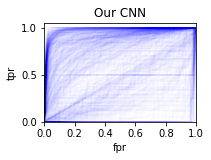

In [36]:
plt.figure()
plt.subplot(223)

our_scores = []
# for i in np.arange(919 - 126):
for i in np.arange(126, 919) - 126:
    fpr, tpr, _ = roc_curve(all_targets[:, i],all_logits[:, i])
    try:
        our_scores += [roc_auc_score(all_targets[:, i],all_logits[:, i])]
    except:
        continue
    plt.plot(fpr, tpr, alpha=0.01, color = "blue")


    plt.xlabel('fpr')
    plt.ylabel('tpr')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Our CNN')

print(np.mean(our_scores))
plt.show()
# all_targets = loadmat("../../genomics/deepsea_train/valid.mat")["validdata"]
# print("done loading")
# plt.subplot(221)
# probs = []
# for s in ["0", "1", "2", "3"]:
#     with open("../../genomics/fastas/infile.fasta" + s + ".out", "r") as f:
#         for l in f:
#             break
#         for l in f:
#             probs_for_l = [float(i) for i in l.split(",")[2:]]
#             probs += [probs_for_l]
            
# probs = np.stack(probs)
            
# scores = []
# for i in np.arange(919):
#     if i % 100 == 0:
#         print(i)
#     fpr, tpr, _ = roc_curve(all_targets[:,i],probs[:,i])
#     try:
#         scores += [roc_auc_score(all_targets[:,i],probs[:,i])]
#     except:
#         continue
#     plt.plot(fpr, tpr, alpha=0.01, color = "blue")

#     plt.ylabel('tpr')
#     plt.tick_params(
#     axis='x',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     bottom='off',      # ticks along the bottom edge are off
#     top='off',         # ticks along the top edge are off
#     labelbottom='off') # labels along the bottom edge are off
#     plt.ylim([0.0, 1.05])
#     plt.xlim([0.0, 1.0])
#     plt.title('DeepSea')
    


# plt.show()
# print(np.mean(scores))

# print(np.count_nonzero(np.array(our_scores) > np.array(scores)))
# plt.hist(our_scores)
# plt.hist(scores)


In [13]:
!pwd

/home/eecs/jwhughes/epitome/bionetz


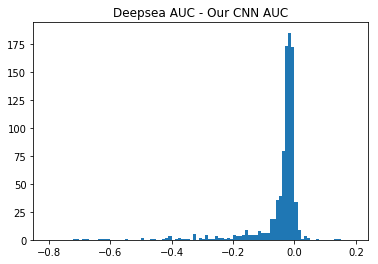

In [18]:
plt.hist(np.array(our_scores) - np.array(scores), bins = np.arange(-.8,.2,.01))
plt.title("Deepsea AUC - Our CNN AUC")
plt.show()

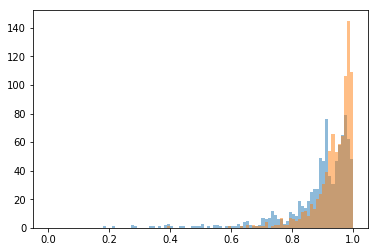

In [19]:
plt.hist(our_scores, alpha = .5, bins = np.arange(0,1.01,.01))
plt.hist(scores, alpha = .5, bins = np.arange(0,1.01,.01))
plt.show()

In [ ]:
tmp = h5py.File("../genomics/results-hdf5/CEBPB-A549.hdf5", "r")
a5_labels = tmp['label']
a5_seq = tmp['seq']
tmp = h5py.File("../genomics/results-hdf5/CEBPB-H1Hesc.hdf5", "r")
h1_labels = tmp['label']
h1_seq = tmp['seq']
tmp = h5py.File("../genomics/results-hdf5/CEBPB-HCT116.hdf5", "r")
hc_labels = tmp['label']
hc_seq = tmp['seq']
tmp = h5py.File("../genomics/results-hdf5/CEBPB-IMR90.hdf5", "r")
im_labels = tmp['label']
im_seq = tmp['seq']

def cell_batches(batch_size, input_, target):
    for i in xrange(int(input_.shape[0]/batch_size)):
        yield input_[i*batch_size:(i+1)*batch_size,0:1000,0:4], target[i*batch_size:(i+1)*batch_size]  


In [24]:
indicies = []
titles = []

with open("../../genomics/DeepSEA-v0.94/resources/feature_name") as f:
    for i, row in enumerate(f):
        if i == 0:
            continue
        print(row.split('|'))
indicies, titles

['1\t8988T', 'DNase', 'None\n']
['2\tAoSMC', 'DNase', 'None\n']
['3\tChorion', 'DNase', 'None\n']
['4\tCLL', 'DNase', 'None\n']
['5\tFibrobl', 'DNase', 'None\n']
['6\tFibroP', 'DNase', 'None\n']
['7\tGliobla', 'DNase', 'None\n']
['8\tGM12891', 'DNase', 'None\n']
['9\tGM12892', 'DNase', 'None\n']
['10\tGM18507', 'DNase', 'None\n']
['11\tGM19238', 'DNase', 'None\n']
['12\tGM19239', 'DNase', 'None\n']
['13\tGM19240', 'DNase', 'None\n']
['14\tH9ES', 'DNase', 'None\n']
['15\tHeLa-S3', 'DNase', 'IFNa4h\n']
['16\tHepatocytes', 'DNase', 'None\n']
['17\tHPDE6-E6E7', 'DNase', 'None\n']
['18\tHSMM_emb', 'DNase', 'None\n']
['19\tHTR8svn', 'DNase', 'None\n']
['20\tHuh-7.5', 'DNase', 'None\n']
['21\tHuh-7', 'DNase', 'None\n']
['22\tiPS', 'DNase', 'None\n']
['23\tIshikawa', 'DNase', 'Estradiol_100nM_1hr\n']
['24\tIshikawa', 'DNase', '4OHTAM_20nM_72hr\n']
['25\tLNCaP', 'DNase', 'androgen\n']
['26\tMCF-7', 'DNase', 'Hypoxia_LacAcid\n']
['27\tMedullo', 'DNase', 'None\n']
['28\tMelano', 'DNase', 'None\n'

([], [])

In [ ]:
with tf.Session() as sess:
    if glob.glob(save_path + '*'):
        saver.restore(sess, save_path)
        print("Model restored.")
    else:
        raise

    for idx in [4]:
        input_ = h1_seq
        targs = h1_labels

        batches = cell_batches(32, input_, targs)
        all_logits_cell = []
        all_targets_cell = []
        i = 0
        for b, t in batches:
            _logits = sess.run(logits, feed_dict={
                input_placeholder: b
            })
            all_logits_cell += _logits[:,idx].tolist()
            all_targets_cell += t.flatten().tolist()
            i += 1
            if i == 100:
                break
        all_logits_cell = np.array(all_logits_cell)
        all_targets_cell = np.array(all_targets_cell)
#         fpr, tpr, _ = roc_curve(all_targets_cell,all_logits_cell)

#         plt.plot(fpr, tpr, color = "blue")
#         print(roc_auc_score(all_targets_cell,all_logits_cell))
#         print(all_logits_cell[0:10])
#         plt.show()
        plt.hist(all_logits_cell[all_targets_cell == 0], alpha = .5, bins = np.arange(0,1.01,.001), density = True, label = "Our data")



In [ ]:
plt.hist(all_logits_cell[all_targets_cell == 0], alpha = .5, bins = np.arange(0,1.01,.001), density = True, label = "Our data")
plt.hist(all_logits[:,idx][all_targets[:,idx] == 0],alpha = .5, bins = np.arange(0,1.01,.001), density = True, label = "Their data")
plt.title("Negative Examples")
plt.legend()
plt.show()